<a href="https://colab.research.google.com/github/HarlinLee/BlobOT/blob/main/POT_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U https://github.com/PythonOT/POT/archive/master.zip # with --user for user install (no root)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/PythonOT/POT/archive/master.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/MyDrive/BlobOT-final"

import sys
sys.path.insert(0, DRIVE_PATH)

import pickle
import torch
import datetime
date = datetime.datetime.today().strftime("%y%m%d")
print(date)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
230531


In [3]:
from BlobOT import KE, NLE, NLE_cons, NLE_pos, Model
from BlobOT import draw_straight_lines, EarlyStopping

def blobLoss(X, model, positive=False):
  if not positive:
    return KE(X, m.z, m.params) + NLE(X, m.w, m.params)
  else:
    return KE(X, m.z, m.params) + NLE_pos(X, m.w, m.params)


def training_loop(model, optimizer, n=10000):
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True,
                                                         patience=30, threshold=0,
                                                         factor=0.5)
  early_stopping = EarlyStopping(patience=100)

  losses=[]

  for i in range(1, 1+n):
    preds = model()
    loss = blobLoss(preds, model)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    scheduler.step(loss)
    early_stopping(loss)
    losses.append(loss.detach().numpy())

    if early_stopping.early_stop:
      print("Early stopping at", i, 'out of', n)
      return np.array(losses)
    
    if i in [int(1e3), int(1e4), int(1e5)] or i % int(5*1e5) == 0:
      print(i)
      X = model.X.data.numpy()
      plot_2d_paths(X, w, z, losses, model, params=params)


  return np.array(losses)

                            

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import ot 
import ot.plot


def plot_2d_paths(X, w, z, losses, model, params=None):
  fig, ax = plt.subplots(2, 2, figsize=(2*5, 2*5))

  # plot the Python OT output
  M = ot.dist(z, w)
  M /= M.max()
  N = params['N']

  a, b = np.ones((N,)) / N, np.ones((N,)) / N  # uniform distribution on samples
  G0 = ot.emd(a, b, M)

  plt.sca(ax[1, 0])
  ot.plot.plot2D_samples_mat(z, w, G0, c=[.5, .5, 1])
  ax[1, 0].plot(z[:, 0], z[:, 1], '+b')
  ax[1, 0].plot(w[:, 0], w[:, 1], 'xr')

  # plot loss function
  # get POT in our format to calculate blobloss
  ind_ot = np.argwhere(G0)
  assert np.all(ind_ot == ind_ot[np.sort(ind_ot[:, 0])])

  X_ot = draw_straight_lines(z, w[ind_ot[:,1]], params['L']+1)
  X_ot = torch.Tensor(X_ot.astype(np.float32))

  X_tensor = torch.Tensor(X)
  
  print()
  print('POT')
  print('loss:', blobLoss(X_ot, model, positive=True).numpy())
  print('kinetic energy:', KE(X_ot, model.z, params).numpy())
  print('nonlocal energy:', NLE_pos(X_ot, model.w, params).numpy())
  print()
  print('BlobOT')
  print('loss:', blobLoss(X_tensor, model, positive=True).numpy())
  print('kinetic energy:', KE(X_tensor, model.z, params).numpy())
  print('nonlocal energy:', NLE_pos(X_tensor, model.w, params).numpy())

  loss_ot = blobLoss(X_ot, model, positive=True).numpy()

  if type(losses) == list:
    losses = np.array(losses)

  steps = range(1, 1+len(losses))

  ax[1, 1].plot(steps, losses+NLE_cons(model.w, params).numpy(), label='Blob OT')
  ax[1, 1].plot(steps, loss_ot*np.ones_like(steps), 'r--', label='POT-emd')
  ax[1, 1].set_xscale('log')
  ax[1, 1].set_yscale('log')

  # plot ours
  y = X[:,:,-1]
  if X.shape[-1] <= params['L']:
    X = np.concatenate((np.expand_dims(z, axis=-1), X), axis=-1)

  for p in range(X.shape[0]):
    traj = X[p].T
    ax[0, 0].plot(traj[:, 0], traj[:, 1],  color=[.5, .5, 1])
  
  ax[0, 0].scatter(X[:, 0, 0], X[:, 1, 0], marker='+', c='b')
  ax[0, 0].scatter(w[:, 0], w[:, 1], marker='x', c='r')

  # plot ours without trajectory
  z = X[:, :, 0]
  ax[0, 1].scatter(z[:, 0], z[:, 1], marker='+', c='b', label='Source')
  ax[0, 1].scatter(w[:, 0], w[:, 1], marker='x', c='r', label='Target')
  ax[0, 1].scatter(y[:, 0], y[:, 1], marker='.', c='k', label='x(1)')

  if params is not None and 'sigma' in params:
    circlew = plt.Circle( (w[0, 0], w[0, 1]), params['sigma'], fill=False, edgecolor='r', alpha=0.3)
    ax[0, 1].add_patch(circlew)
  
  # set labels
  tick_kwarg = dict(labelsize=16)
  kwarg = dict(fontsize=24)
  leg_kwarg = dict(fontsize=16, markerscale=2)

  ax[1, 0].set_title('POT-emd',**kwarg)
  ax[1, 1].set_title('Objective function value', **kwarg)
  ax[0, 0].set_title('Blob OT', **kwarg)
  ax[0, 1].set_title('Blob OT (w/o trajectory)', **kwarg)

  ax[0, 0].set_xticks([])
  ax[0, 0].set_yticks([])
  ax[0, 1].set_xticks([])
  ax[0, 1].set_yticks([])

  ax[1, 0].set_yticks([0, 0.5, 1, 1.5, 2])
  ax[1, 1].set_yticks([1, 10, 100], [1, 10, 100])

  ax[1, 0].xaxis.set_tick_params(**tick_kwarg)
  ax[1, 0].yaxis.set_tick_params(**tick_kwarg)
  ax[1, 1].xaxis.set_tick_params(**tick_kwarg)
  ax[1, 1].yaxis.set_tick_params(**tick_kwarg)

  ax[0, 1].legend(**leg_kwarg)
  ax[1, 1].legend(**leg_kwarg)

  # share x, y axis
  cells = [ax[0, 0], ax[0, 1], ax[1, 0]]

  ylims = np.array([a.get_ylim() for a in cells])
  xlims = np.array([a.get_xlim() for a in cells])
  for cell in cells:
    cell.set_ylim((ylims.min(axis=0)[0], ylims.max(axis=0)[1]))
    cell.set_xlim((xlims.min(axis=0)[0], xlims.max(axis=0)[1]))

  plt.tight_layout(pad=0)
  plt.savefig(os.path.join(DRIVE_PATH, f'POT_comparison_{date}.pdf'), dpi=300)
  plt.show()

{'N': 30, 'd': 2, 'dt': 0.5, 'L': 2, 'eps': 0.01, 'delta': 0.18570559089848318, 'lr': 0.01, 'n': 1000000}
1000

POT
loss: 1.9908147
kinetic energy: 1.9908223
nonlocal energy: -7.6293945e-06

BlobOT
loss: 1.9940399
kinetic energy: 1.9797729
nonlocal energy: 0.014266968


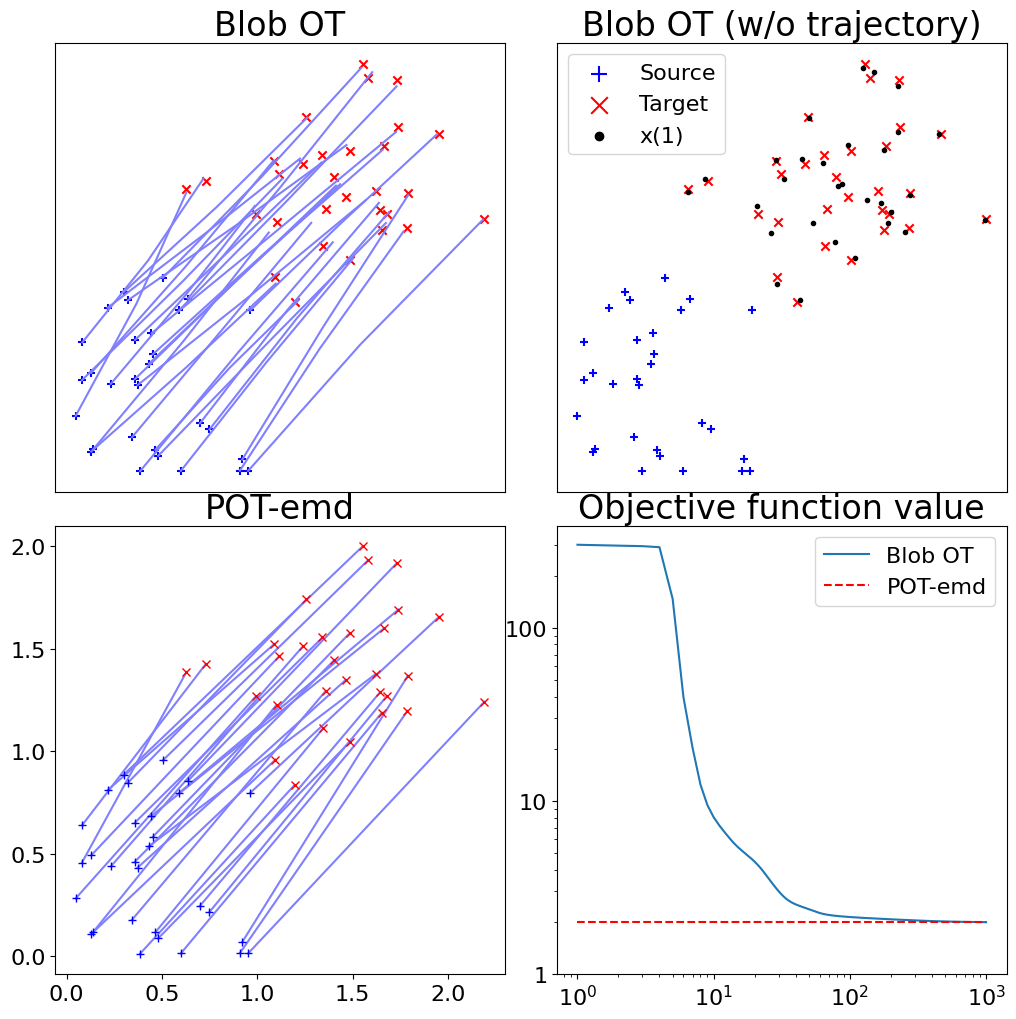

Epoch 01534: reducing learning rate of group 0 to 5.0000e-03.
Epoch 01676: reducing learning rate of group 0 to 2.5000e-03.
Epoch 01730: reducing learning rate of group 0 to 1.2500e-03.
Epoch 01788: reducing learning rate of group 0 to 6.2500e-04.
Epoch 01819: reducing learning rate of group 0 to 3.1250e-04.
Epoch 01856: reducing learning rate of group 0 to 1.5625e-04.
Epoch 01887: reducing learning rate of group 0 to 7.8125e-05.
Epoch 01918: reducing learning rate of group 0 to 3.9063e-05.
Early stopping at 1927 out of 1000000

POT
loss: 1.9908147
kinetic energy: 1.9908223
nonlocal energy: -7.6293945e-06

BlobOT
loss: 1.9883794
kinetic energy: 1.9778584
nonlocal energy: 0.010520935


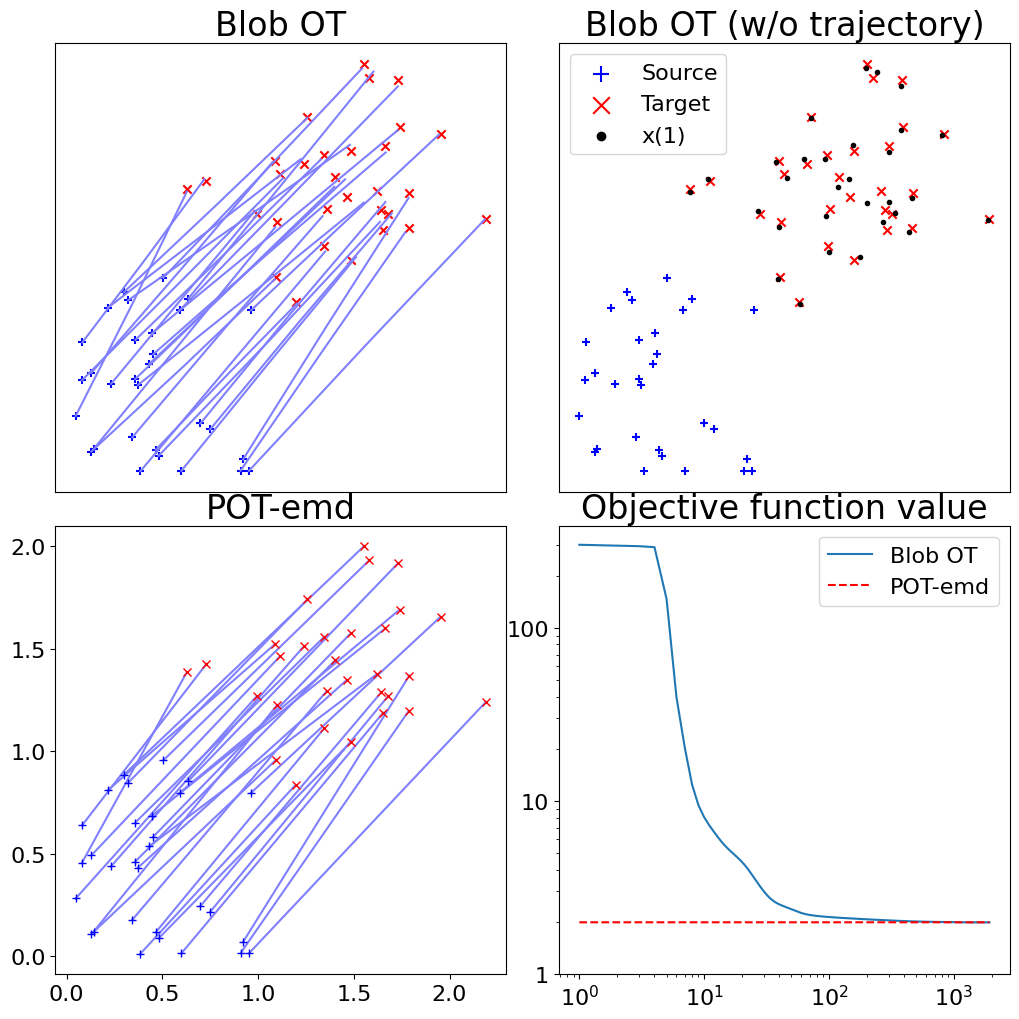

In [5]:
rng = np.random.RandomState(23)

N = 30

d = 2
dt = 0.5
L = int(1/dt)

z = np.random.rand(N, d)
w = 0.3*np.random.randn(N, d) + 1.5

eps = 0.01
lr = eps
gd_steps = int(1e6)
delta = N**(-0.99/d)

params = {'N': N, 'd': d, 'dt': dt, 'L': L, 'eps': eps, 'delta': delta, 'lr': lr, 'n': gd_steps}

print(params)

w_tensor = torch.tensor(w.astype(np.float32))
z_tensor = torch.tensor(z.astype(np.float32))

# initialize to center of target distribution
y0 = np.mean(w, axis=0)
X0 = draw_straight_lines(z, y0, params['L']+1)

# run gradient descent
m = Model(torch.Tensor(X0), w_tensor, z_tensor, params)
opt = torch.optim.SGD(m.parameters(), lr=params['lr'])
losses = training_loop(m, opt, n=params['n'])

X = m.X.data.numpy()

plot_2d_paths(X, w, z, losses, m, params=params)


np.savez(os.path.join(DRIVE_PATH, f'POT_comparison_{date}.npz'), w=w, z=z, X=X, params=params, losses=np.array(losses))



# load data and make figure for paper

In [6]:
# !pip install -U https://github.com/PythonOT/POT/archive/master.zip # with --user for user install (no root)

In [7]:
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# DRIVE_PATH = "/content/drive/MyDrive/BlobOT-final"

# import sys
# sys.path.insert(0, DRIVE_PATH)

import pickle
import torch

import datetime
date = datetime.datetime.today().strftime("%y%m%d")
print(date)

230531


In [8]:
with np.load(os.path.join(DRIVE_PATH, f'POT_comparison_{date}.npz'), allow_pickle=True) as data:
    print(data.files)
    w = data['w']
    z = data['z']
    X = data['X']
    losses = data['losses']
    params = data['params'][()]
    
    print(params)

    w_tensor = torch.tensor(w.astype(np.float32))
    z_tensor = torch.tensor(z.astype(np.float32))

['w', 'z', 'X', 'params', 'losses']
{'N': 30, 'd': 2, 'dt': 0.5, 'L': 2, 'eps': 0.01, 'delta': 0.18570559089848318, 'lr': 0.01, 'n': 1000000}



POT
loss: 1.9908147
kinetic energy: 1.9908223
nonlocal energy: -7.6293945e-06

BlobOT
loss: 1.9883794
kinetic energy: 1.9778584
nonlocal energy: 0.010520935


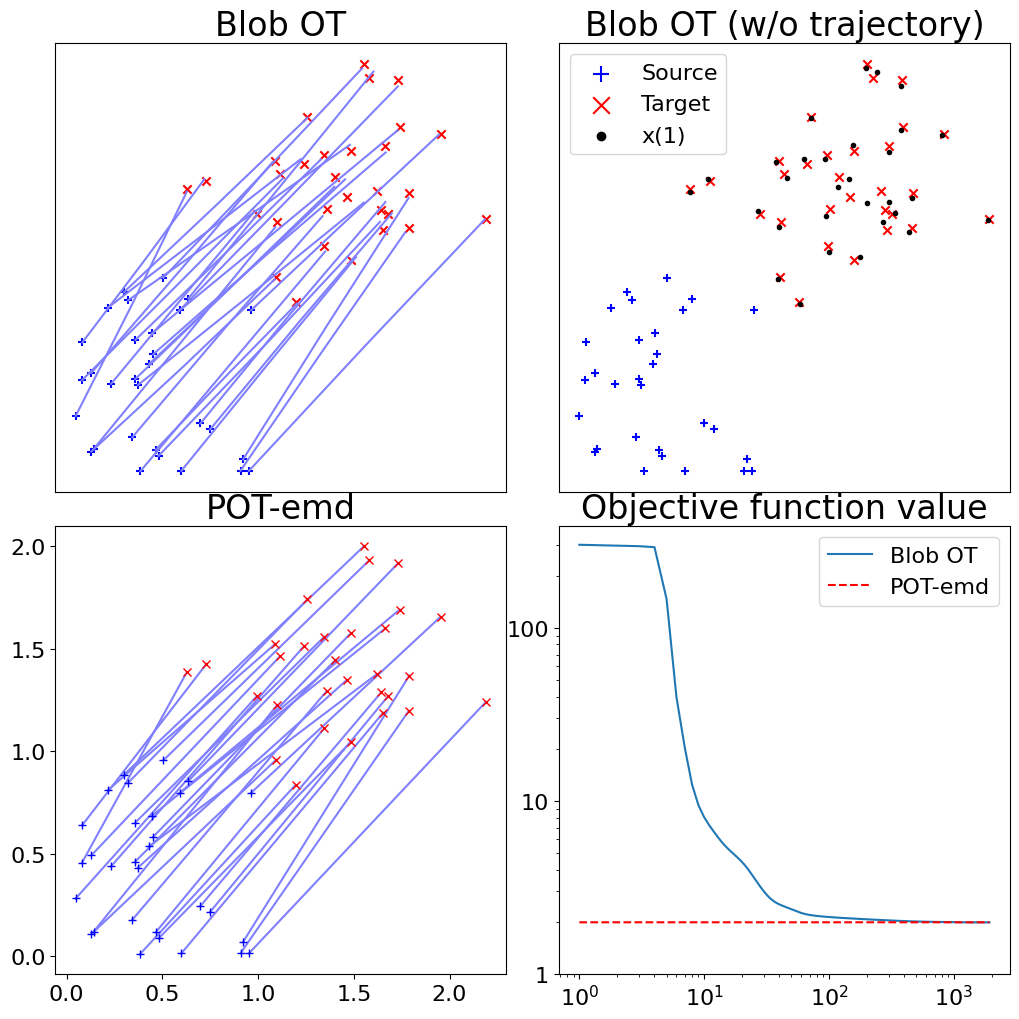

In [9]:
plot_2d_paths(X, w, z, losses, m, params=params)